In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.style.use('../notebooks/style.mpl')

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Respiratory heterotrophy model

In [3]:
eps = 1e-10
tau = 1e-1
S2 = 2.

In [4]:
def het_model( t, y ):
    x = y.copy()
    x[x<eps] = 0.0
    x[x>1e8] = 1e8
    Corg = x[0]
    NADH = x[1]
    O2 = x[2]
    ATP = x[3]
    
    NAD = r1 * NADH
    ADP = r2 * ATP
    
    nu_cat = (NAD ** S2) * phi_cat * gamma_cat_inv * tau
    nu_resp = (NADH ** 2) * phi_resp * gamma_resp_inv * tau
    nu_ana = (NADH ** S6) * (ATP ** S5) * phi_ana * gamma_ana_inv * tau
    
    mu = nu_ana.copy()
    
    # dCorg = - nu_cat - nu_ana + nu_supply - mu * Corg
    dCorg = 0.0
    # dNADH = S2 * nu_cat - 2 * nu_resp - S6 * nu_ana - mu * NADH
    dNADH = 0.0
    dNAD = - dNADH
    dO2 = 0.0
    dATP = (S3 * nu_cat + S4 * nu_resp - S5 * nu_ana - mu * ATP)
    dADP = -dATP
    
    dydt = np.array([dCorg, dNADH, dO2, dATP])
    return dydt

# Regimes of $\frac{d \lambda}{d S_6}$

## Case I: simulation default

For the full model, we have the following expression for how $\lambda$ changes with $S_6$.

$$   \frac{d\lambda}{d S_6} = \frac{(S_2 S_3 + S_1 S_4)}{\left(S_1 \left(ATP +S_5\right) - S_3
   \left(NADH + S_6\right)\right){}^2} \cdot \left[ \frac{\partial J_{resp}}{\partial S_6} \left(S_1 \left(ATP + S_5\right) - S_3 \left(NADH +S_6\right)\right) - J_{resp} \left(S_1 \frac{\partial (ATP)}{\partial S_6} - S_3 \frac{\partial (NADH)}{\partial S_6}\right)
  \right]$$

Since we are interested in the sign of $\frac{d \lambda}{d S_6}$, and the term outside the square brackets is always positive, we have:

$$   \text{sign}\left[\frac{d\lambda}{d S_6}\right] =  \text{sign}\left[ \frac{\partial J_{resp}}{\partial S_6} \left(S_1 \left(ATP + S_5\right) - S_3 \left(NADH +S_6\right)\right) - J_{resp} \left(S_1 \frac{\partial (ATP)}{\partial S_6} - S_3 \frac{\partial (NADH)}{\partial S_6}\right)
  \right]$$

We can now study different regimes of our simulations to understand the sign of $\frac{d \lambda}{d S_6}$. One of the simplest regimes is the one implemented in Fig. 1 of the main text, where we assume homeostatic NADH concentrations, but dynamic ATP concentrations. In this regime:

$$ \frac{\partial (NADH)}{\partial S_6} = 0 $$

$$   \text{sign}\left[\frac{d\lambda}{d S_6}\right] =  \text{sign}\left[ \frac{\partial J_{resp}}{\partial S_6} \left(S_1 \left(ATP + S_5\right) - S_3 \left(NADH +S_6\right)\right) - J_{resp} \left(S_1 \frac{\partial (ATP)}{\partial S_6}\right)
  \right]$$

Since $J_{resp} = (NADH)^{S_2} \phi_{resp} \gamma_{resp}^{-1}$, we have:

$$ \frac{\partial J_{resp}}{\partial S_6} = (NADH)^{S_2}\frac{\partial \phi_{resp}}{\partial S_6} \gamma^{-1}_{resp} $$

In our simulations, we observe (i) small changes in the optimal $\phi_{resp}$ with increasing $S_6$ compared with changes in the steady state ATP concentration ATP $\ast$, and (ii) thus, the first term in the expression for $\text{sign}\left[\frac{d\lambda}{d S_6}\right]$ is much smaller than the second. Using these, we see that:

$$   \text{sign}\left[\frac{d\lambda}{d S_6}\right] \approx  \text{sign}\left[ - S_1 J_{resp} \left( \frac{\partial (ATP)}{\partial S_6}\right)
  \right]$$

Thus, in our simulations, $\lambda$ and the steady state ATP concentration face opposite effects due to perturbing $S_6$. Decreasing ATP $\ast$ with increasing $S_6$ would be needed to increase $\lambda$, i.e.:

$$ \frac{\partial (ATP)^\ast}{\partial S_6} < 0 \implies \frac{d\lambda}{d S_6} > 0 $$

Below, using simulations, we show that a decrease in ATP $\ast$ with increasing $S_6$ is indeed observed as a result of dynamic ATP balance.

# Simulations

### Parameters

In [17]:
# gamma inverses are in /hr units.
gamma_cat_inv = 1000/3600
gamma_resp_inv = 1000/3600
gamma_ana_inv = 1000/3600

phi_cat = 0.5
phi_ana = 0.4
phi_resp = 0.1

# Default params: reliance on respiration.
S4 = 4.0    # ATP yield of respiration
S3 = 0.3    # ATP yield of catabolism ... NOTE: default should be 0.5
S5 = 1.1    # ATP cost of anabolism
S6 = 0.2    # reduction coefficient of biomass

### Initial conditions

In [6]:
# concentrations in KM units
Corg0 = 1e1
NADH0 = 2e0
O20 = 1e1
ATP0 = 1e0

# KM is in uM
KM = 100
r1 = 10.
r2 = 0.1

### Dynamics

In [7]:
y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
NUM_METS = len(y0)

# Evaluation time
TFINAL = 1e6
t = np.logspace(-4, 2, 1000 )
S6 = 0.1

In [8]:
def give_nus( y_sol, tpt ):
    x = y_sol[:, tpt].copy()
    Corg = x[0]
    NADH = x[1]
    O2 = x[2]
    ATP = x[3]

    NAD = r1 * NADH
    ADP = r2 * ATP

    nu_cat = (NAD ** 2) * phi_cat * gamma_cat_inv * tau
    nu_resp = (NADH ** 2) * phi_resp * gamma_resp_inv * tau
    nu_ana = (NADH ** S6) * (ATP ** S5) * phi_ana * gamma_ana_inv * tau
    
    return np.array([nu_cat, nu_resp, nu_ana])

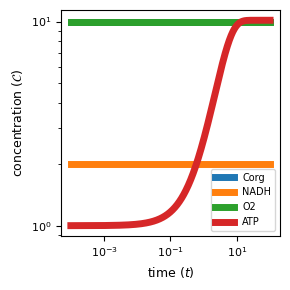

In [10]:
y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y

fig, ax = plt.subplots( 1, 1, figsize=(3,3) )

ax.set_ylabel( 'concentration (' + r'$\mathcal{C}$)')
ax.set_xlabel( 'time (' + r'$t$)')
for idx in range(NUM_METS):
    ax.plot( t[:len(y_sol[idx])], y_sol[idx], lw=5 )
ax.legend([ 'Corg', 'NADH', 'O2', 'ATP' ], loc='best')
ax.set_yscale('log')
ax.set_xscale('log')

fig.tight_layout()
plt.show()

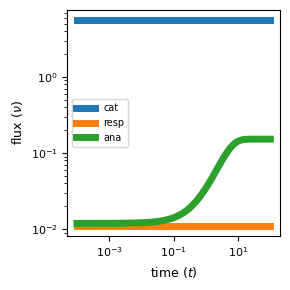

In [12]:
nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

fig, ax = plt.subplots( 1, 1, figsize=(3,3) )

ax.set_ylabel( 'flux (' + r'$\nu$)')
ax.set_xlabel( 'time (' + r'$t$)')
for idx in range(3):
    ax.plot( t[:len(nus[idx])], nus[idx], lw=5 )
ax.legend([ 'cat', 'resp', 'ana' ], loc='best')
ax.set_yscale('log')
ax.set_xscale('log')

fig.tight_layout()
plt.show()

## Sweeping over $S_6$

In [13]:
atps = []
mus = []
zcs = []

for S6 in np.linspace(-0.1, 0.5, 100):
    y0 = np.array([Corg0, NADH0, O20, ATP0])
    NUM_METS = len(y0)

    # Evaluation time
    TFINAL = 1e6
    t = np.logspace(-4, 6, 1000)

    y_sol = solve_ivp(het_model, [1e-4, TFINAL], y0, t_eval=t, method='Radau').y

    nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

    atps.append(y_sol[-1, -1])
    mus.append(nus[-1, -1])
    zcs.append(S6)
    
df = pd.DataFrame({'atps': atps, 'zcs': zcs})

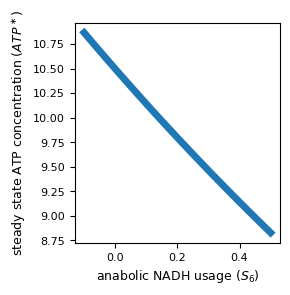

In [14]:
fig, ax = plt.subplots( 1, 1, figsize=(3, 3) )

ax.set_ylabel( 'steady state ATP concentration (' + r'$ATP^\ast$)')
ax.set_xlabel( 'anabolic NADH usage (' + r'$S_6$)')
ax.plot( df['zcs'], df['atps'], lw=5 )

fig.tight_layout()
plt.show()

## Robustness to optimizing $\phi$'s

Above, we assumed that the optimal allocation fractions $\phi_\alpha$ were relatively insensitive to changes in $S_6$. Below, we show that even when optimizing the $\phi$'s, we are still in the regime where $\frac{\partial (ATP)^\ast}{\partial S_6} < 0$.

In [15]:
opt_atps = []
opt_phi_resps = []
zcs = []

phi_o = 0.4 # allocation to housekeeping sector

for S6 in np.linspace(-0.1, 0.5, 100):
    # optimizing 
    cats_to_sample = np.linspace(0.1, 0.5, 10)
    resps_to_sample = np.linspace(0.01, 0.2, 10)

    allatps, allmus, allphis = [], [], []
    for phi_cat in cats_to_sample:
        for phi_resp in resps_to_sample:
            phi_ana = 1-phi_cat-phi_resp-phi_o

            y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
            NUM_METS = len(y0)

            # Evaluation time
            TFINAL = 1e6
            t = np.logspace(-4, 6, 1000 )

            y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y

            nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T
            
            allatps.append(y_sol[-1, -1])
            allmus.append(nus[-1, -1])
            allphis.append([phi_cat, phi_resp, phi_ana])

    mus = np.array(allmus)
    max_index = np.argmax(mus)  # finding growth-optimal index
    phi_cat, phi_resp, phi_ana = allphis[max_index] # optimal phis

    # storing optimized ATP* and optimal phi_resp.
    opt_atps.append(allatps[max_index])
    opt_phi_resps.append(phi_resp)
    zcs.append(S6)

df = pd.DataFrame({'atps': opt_atps, 'zcs': zcs, 'optphiresps': opt_phi_resps})

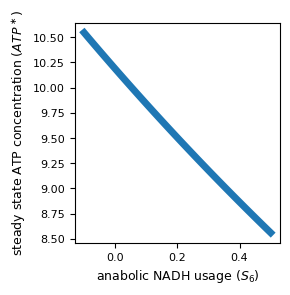

In [16]:
fig, ax = plt.subplots( 1, 1, figsize=(3, 3) )

ax.set_ylabel( 'steady state ATP concentration (' + r'$ATP^\ast$)')
ax.set_xlabel( 'anabolic NADH usage (' + r'$S_6$)')
ax.plot( df['zcs'], df['atps'], lw=5 )

fig.tight_layout()
plt.show()